In [2]:
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil
import glob 
from tqdm import tqdm
from multiprocessing import Pool, cpu_count
from itertools import combinations
# custom functions
from wrangle_utils import *

needs the following folder structure:
```
- Project:
    - src:
        - wrangling_utils.py
        - delete_tickers_flagged_bad.ipynb
    - data:
        - raw:
            - unmerged:
                - ticker
                    -  *-trade.parquet
                    .
                    .
                    .
                .
                .
                .
            - merged:
                - empty
        clean:
            - empty

```

In [6]:
run_flag_bad = True
run_merging = True
run_cleaning = True
run_filtering = True
run_deGARCH = True
comp_hayashi_est = True
run_deGARCH_unfiltered = True


---

## Load available tickers

---

In [3]:
raw_unmerged_path = "../data/raw/"

In [4]:
tickers = os.listdir(raw_unmerged_path)
# extract ticker names from file names
tickers = [ticker.split("-")[1] if "-" in str(ticker) else ticker for ticker in tickers]

if ".DS_Store" in tickers:
    tickers.remove('.DS_Store')
    print(".DS_Store removed from tickers")
if "deGARCH" in tickers:
    tickers.remove('deGARCH')
    print("deGARCH removed from tickers")
if "SPY-trade.parquet" in tickers:
    tickers.remove('SPY-trade.parquet')
    print("SPY-trade.parquet removed from tickers")

np.save("tickers_filtered.npy", tickers)

.DS_Store removed from tickers


---

## Flag bad tickers 

---

In [7]:
if run_flag_bad:
    flag_bad_folders(tickers, raw_unmerged_path)


Folder 'VZ' renamed to 'bad-VZ'.
Folder 'AMR' renamed to 'bad-AMR'.
Folder 'RCL' renamed to 'bad-RCL'.
Folder 'CAT' renamed to 'bad-CAT'.
Folder 'PM' renamed to 'bad-PM'.
Folder 'CBG' renamed to 'bad-CBG'.
Folder 'PEP' renamed to 'bad-PEP'.
Folder 'CAG' renamed to 'bad-CAG'.
Folder 'MGM' renamed to 'bad-MGM'.
Folder 'UPS' renamed to 'bad-UPS'.
Folder 'EMR' renamed to 'bad-EMR'.
Folder 'MS' renamed to 'bad-MS'.
Folder 'MSS' renamed to 'bad-MSS'.
Folder 'WMT' renamed to 'bad-WMT'.
Folder 'DG' renamed to 'bad-DG'.
Folder 'CVX' renamed to 'bad-CVX'.
Folder 'MO' renamed to 'bad-MO'.
Folder 'TXN' renamed to 'bad-TXN'.
Folder 'UNM' renamed to 'bad-UNM'.
Folder 'BK' renamed to 'bad-BK'.
Folder 'GS' renamed to 'bad-GS'.
Folder 'LOW' renamed to 'bad-LOW'.
Folder 'DFS' renamed to 'bad-DFS'.
Folder 'XRX' renamed to 'bad-XRX'.
Folder 'HIG' renamed to 'bad-HIG'.
Folder 'HD' renamed to 'bad-HD'.
Folder 'IPG' renamed to 'bad-IPG'.
Folder 'LLY' renamed to 'bad-LLY'.
Folder 'HAL' renamed to 'bad-HAL'.
F

In [8]:
# count folders not flagged as bad
good_tickers = [ticker for ticker in tickers if not os.path.exists(os.path.join(raw_unmerged_path, f"bad-{ticker}"))]
print(f"Number of good tickers: {len(good_tickers)}")

Number of good tickers: 305


---

## Merge all files for one ticker

---

In [9]:
raw_merged_path = "../data/raw/merged/"
# if merged folder does not exist, create it
if not os.path.exists(raw_merged_path):
    os.makedirs(raw_merged_path)

In [10]:
if run_merging:
    # merge trade files
    for ticker in tqdm.tqdm(good_tickers):
        merge_trade_files(ticker, raw_unmerged_path, raw_merged_path)
    

100%|██████████| 305/305 [00:46<00:00,  6.62it/s]


In [11]:
## have a look at the merged file
df = pd.read_parquet(os.path.join(raw_merged_path, f"{good_tickers[23]}-trade.parquet"))
print("Shape of the merged file: ", df.shape)
print("Columns of the merged file: ", df.columns)
df.head()

Shape of the merged file:  (97904, 5)
Columns of the merged file:  Index(['xltime', 'trade-price', 'trade-volume', 'trade-stringflag',
       'trade-rawflag'],
      dtype='object')


,xltime,trade-price,trade-volume,trade-stringflag,trade-rawflag
0,40301.542427,77.39,112,marketclosed|volumeupdate,[CTS_QUAL ] ...
1,40301.563200,77.97,2300,auction,[CTS_QUAL ]O ...
2,40301.563200,78.26,100,uncategorized,[CTS_QUAL ]MSW ...
3,40301.564060,78.30,100,uncategorized,[CTS_QUAL ]MSW ...
4,40301.564061,78.30,100,uncategorized,[CTS_QUAL ] ...


<Axes: xlabel='xltime'>

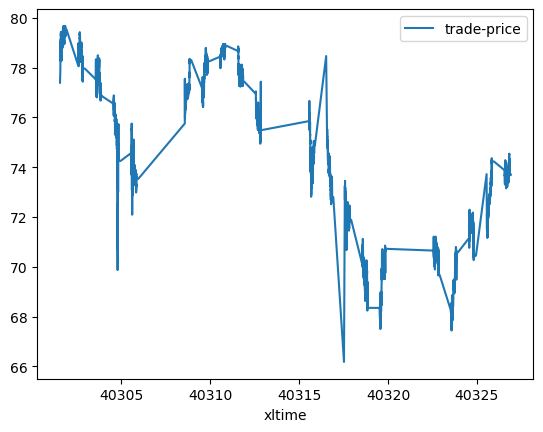

In [12]:
# plot time series of the first merged file
df.plot(x='xltime', y = 'trade-price')

Might seem plausible to just look at one specific day of the month to avaiod sparsity in the data. Approach: Take first day of the month and keep all tickers which have at least 10_000 entries.

---
## Clean Data and save
---

In [13]:
clean_unfiltered_path = "../data/clean/unfiltered/"
if not os.path.exists(clean_unfiltered_path):
    os.makedirs(clean_unfiltered_path)

In [14]:
if run_cleaning:
    clean_and_save_trade_files(
        good_tickers, 
        raw_merged_path, 
        clean_unfiltered_path, 
        only_non_special_trades=True,
        only_regular_trading_hours=True,
        merge_sub_trades=True,
    )

100%|██████████| 305/305 [00:44<00:00,  6.91it/s]


In [15]:
# have a look at the cleaned file
df = pd.read_parquet(os.path.join(clean_unfiltered_path, f"{good_tickers[12]}-trade.parquet"))
print("Shape of the cleaned file: ", df.shape)
print("Columns of the cleaned file: ", df.columns)
df.head()


Shape of the cleaned file:  (1146370, 2)
Columns of the cleaned file:  Index(['index', 'log-return'], dtype='object')


,index,log-return
0,2010-05-03 09:30:00.989000-04:00,-0.001191
1,2010-05-03 09:30:01.010000-04:00,0.000000
2,2010-05-03 09:30:01.531000-04:00,-0.000596
3,2010-05-03 09:30:01.638000-04:00,0.001192
4,2010-05-03 09:30:01.659000-04:00,-0.001192


<Axes: xlabel='index'>

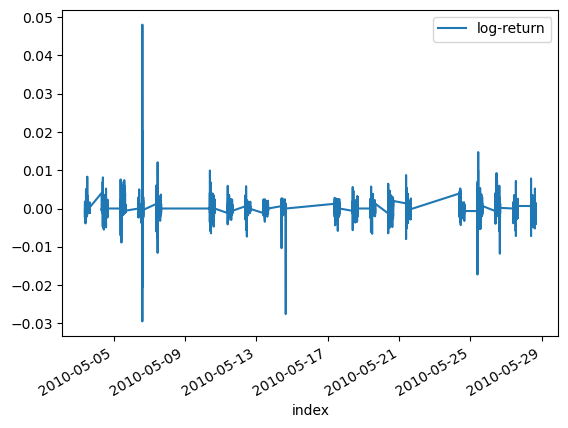

In [16]:
df.plot(x='index', y = 'log-return')

Number of observations for the specific date:  47967


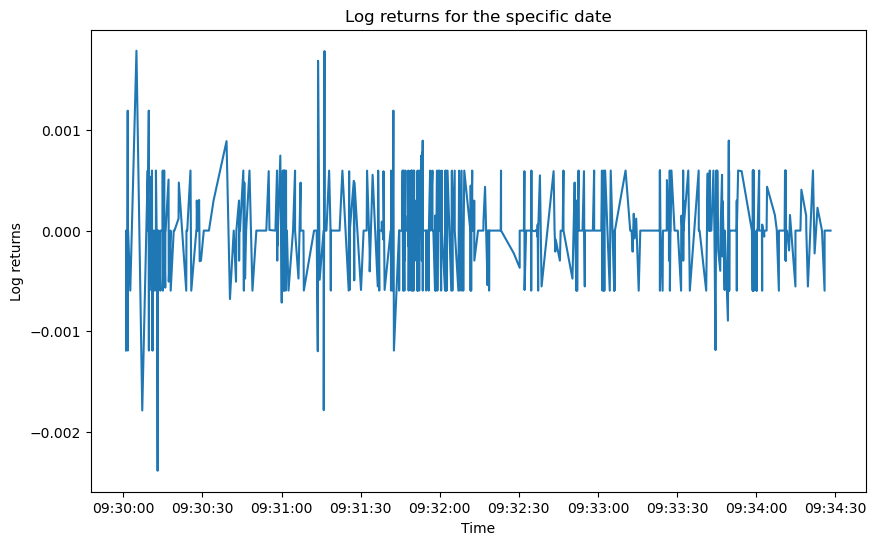

In [17]:
df['index'] = pd.to_datetime(df['index'])  # Ensure the index column is in datetime format

# Filter rows for the specific date
filtered_df = df[df['index'].dt.date == pd.to_datetime('2010-05-03').date()]
print("Number of observations for the specific date: ", filtered_df.shape[0])
plt.figure(figsize=(10, 6))
plt.plot(filtered_df['index'].iloc[:1000,], filtered_df['log-return'].iloc[:1000,])
plt.title('Log returns for the specific date')
plt.xlabel('Time')
plt.ylabel('Log returns')
plt.show()



--- 
## Filter data according to number of observations
---

In [18]:
clean_filtered_path = "../data/clean/filtered/"
if not os.path.exists(clean_filtered_path):
    os.makedirs(clean_filtered_path)

# filter tickers which have less than min_obs observations for the specific date
min_obs = 1_000
target_day = '2010-05-03'

if run_filtering:
    filter_tickers_by_obs(
        directory_path=clean_unfiltered_path,
        target_directory_path=clean_filtered_path,
        min_obs=min_obs,
        day=target_day,
        )

100%|██████████| 305/305 [00:59<00:00,  5.15it/s]

Number of tickers kept: 278


---
# DeGARCH the filtered data
---

In [17]:
from wrangling_utils import de_garch_returns_parallel, de_garch_returns

clean_deGARCH_path = "../data/clean/deGARCH/filtered/"
if not os.path.exists(clean_deGARCH_path):
    os.makedirs(clean_deGARCH_path)

# get tickers of the filtered files
tickers_filtered = os.listdir(clean_filtered_path)
tickers_filtered = [ticker.split("-")[0] if "-" in str(ticker) else ticker for ticker in tickers_filtered]

if ".DS_Store" in tickers_filtered:
    tickers_filtered.remove('.DS_Store')
    print(".DS_Store removed from tickers")
if "deGARCH" in tickers_filtered:
    tickers_filtered.remove('deGARCH')
    print("deGARCH removed from tickers")
if "SPY-trade.parquet" in tickers_filtered:
    tickers_filtered.remove('SPY-trade.parquet')
    print("SPY-trade.parquet removed from tickers")

print(f"Number of tickers after filtering: {len(tickers_filtered)}")


if run_deGARCH:
    de_garch_returns_parallel(
        tickers=tickers_filtered,
        max_p= 3,
        max_q= 3,
        criterion="BIC",
        scaling=10**4,
        target_directory_path=clean_deGARCH_path,
        directory_path=clean_filtered_path,
    )




Number of tickers after filtering: 277


In [18]:
# plot the deGARCHed returns
df = pd.read_parquet(os.path.join(clean_deGARCH_path, f"{tickers_filtered[250]}-trade.parquet"))
print("Shape of the deGARCHed file: ", df.shape)
print("Columns of the deGARCHed file: ", df.columns)
df.head()


Shape of the deGARCHed file:  (5718, 3)
Columns of the deGARCHed file:  Index(['index', 'log-return', '__index_level_0__'], dtype='object')


,index,log-return,__index_level_0__
0,2010-05-03 09:30:01.835000-04:00,1.638982e-07,0
1,2010-05-03 09:30:17.321000-04:00,2.414701e-04,1
2,2010-05-03 09:30:25.961000-04:00,6.177183e-05,2
3,2010-05-03 09:30:43.446000-04:00,-1.397614e-04,3
4,2010-05-03 09:30:43.703000-04:00,1.387838e-07,4


<Axes: xlabel='index'>

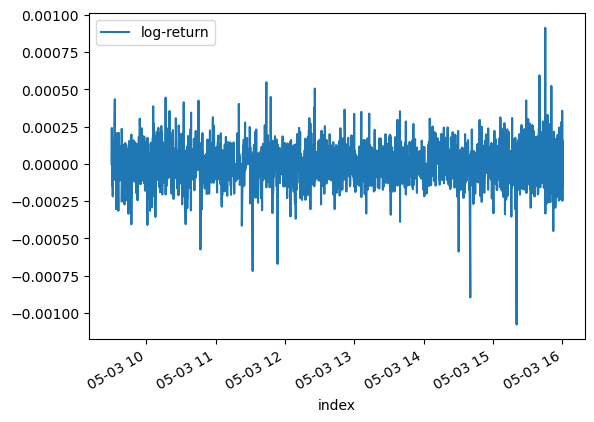

In [19]:
# plot time series of the first deGARCHed file
df.plot(x='index', y = 'log-return')


---
## Compute Hayashi-Yoshida estimator on deGARCHed data
---

In [20]:
# get tickers of the deGARCHed files
tickers_deGARCH = os.listdir(clean_deGARCH_path)
tickers_deGARCH = [ticker.split("-")[0] if "-" in str(ticker) else ticker for ticker in tickers_deGARCH]

if ".DS_Store" in tickers_deGARCH:
    tickers_deGARCH.remove('.DS_Store')
    print(".DS_Store removed from tickers")
if "deGARCH" in tickers_deGARCH:
    tickers_deGARCH.remove('deGARCH')
    print("deGARCH removed from tickers")
if "SPY-trade.parquet" in tickers_deGARCH:
    tickers_deGARCH.remove('SPY-trade.parquet')
    print("SPY-trade.parquet removed from tickers")




In [21]:


if comp_hayashi_est:
    # compute covariance matrix
    cov_matrix = np.zeros((len(tickers_deGARCH), len(tickers_deGARCH)))

    for i, ticker1 in tqdm.tqdm(enumerate(tickers_deGARCH)):
        #print(f"Calculating correlations for asset {tickers_deGARCH}")

        for j, ticker2 in enumerate(tickers_deGARCH):
            if i<j:
                continue
            
            cov_matrix[i, j] = hayashi_yoshida_high_frequency(
                                    ticker1, 
                                    ticker2,
                                    directory_path=clean_deGARCH_path,
                                    scale=10**4,
                                )
            cov_matrix[j, i] = cov_matrix[i, j]
    

In [23]:
# try other method
cov_matrix2 = np.zeros((len(tickers_deGARCH), len(tickers_deGARCH)))

for i, ticker1 in tqdm.tqdm(enumerate(tickers_deGARCH)):
    #print(f"Calculating correlations for asset {ticker1}")

    for j, ticker2 in enumerate(tickers_deGARCH):
        if i<j:
            continue

        asset1 = pd.read_parquet(f"{clean_deGARCH_path}{ticker1}-trade.parquet")
        asset2 = pd.read_parquet(f"{clean_deGARCH_path}{ticker2}-trade.parquet")

        asset_merged = asset1.merge(asset2, on="index", how="outer")
        asset_merged = asset_merged.ffill().bfill()

        cov_matrix2[i, j] = sum(asset_merged["log-return_x"].to_numpy()*asset_merged["log-return_y"].to_numpy()) / asset_merged.shape[0]
        cov_matrix2[j, i] = cov_matrix2[i, j]

277it [03:40,  1.26it/s]


In [24]:
cov_matrix2[:5, :5]

array([[7.92343520e-09, 7.18675816e-11, 6.57479924e-10, 2.16331247e-07,
        2.85030175e-09],
       [7.18675816e-11, 7.03601371e-09, 4.30478484e-10, 3.49427029e-08,
        2.01628310e-09],
       [6.57479924e-10, 4.30478484e-10, 9.96069716e-09, 1.87236526e-07,
        1.92053406e-07],
       [2.16331247e-07, 3.49427029e-08, 1.87236526e-07, 3.64893610e-03,
        8.46799814e-06],
       [2.85030175e-09, 2.01628310e-09, 1.92053406e-07, 8.46799814e-06,
        4.96215451e-06]])

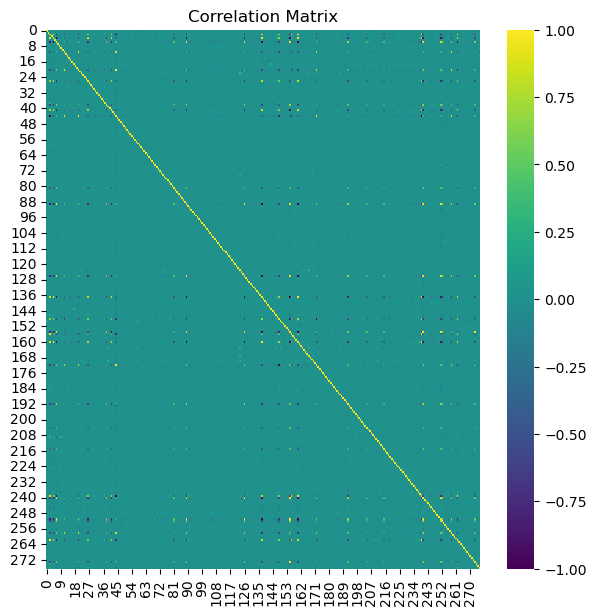

(277, 277)


In [35]:
pd.DataFrame(cov_matrix2).to_csv("correlation/covariance_hy_0305.csv")
corr_matrix2 = correlation_from_covariance(cov_matrix2)
pd.DataFrame(corr_matrix2).to_csv("correlation/correlation_hy_0305.csv")
# plot correlation matrix
plt.figure(figsize=(7, 7))
sns.heatmap(corr_matrix2, annot=False, cmap='viridis', vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.show()

print(np.shape(corr_matrix2))

--- 
## Compute the Hayashi-Yoshida estimator on the original data
---


In [39]:
clean_deGARCH_unfiltered_path = "../data/clean/deGARCH/unfiltered/"
if not os.path.exists(clean_deGARCH_path):
    os.makedirs(clean_deGARCH_path)

# get tickers of the filtered files
tickers_filtered = os.listdir(clean_unfiltered_path)
tickers_filtered = [ticker.split("-")[0] if "-" in str(ticker) else ticker for ticker in tickers_filtered]

if ".DS_Store" in tickers_filtered:
    tickers_filtered.remove('.DS_Store')
    print(".DS_Store removed from tickers")
if "deGARCH" in tickers_filtered:
    tickers_filtered.remove('deGARCH')
    print("deGARCH removed from tickers")
if "SPY-trade.parquet" in tickers_filtered:
    tickers_filtered.remove('SPY-trade.parquet')
    print("SPY-trade.parquet removed from tickers")

print(f"Number of tickers after filtering: {len(tickers_filtered)}")


if run_deGARCH_unfiltered:
    de_garch_returns_parallel(
        tickers=tickers_filtered,
        max_p= 3,
        max_q= 3,
        criterion="BIC",
        scaling=10**4,
        target_directory_path=clean_deGARCH_unfiltered_path,
        directory_path=clean_unfiltered_path,
    )


Number of tickers after filtering: 304


/Users/stephanhengl/opt/anaconda3/envs/FinancialBigData/lib/python3.11/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.787e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/stephanhengl/opt/anaconda3/envs/FinancialBigData/lib/python3.11/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.787e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warning

All assets processed.


In [41]:
# get tickers of the deGARCHed files
tickers_deGARCH_unfiltered = os.listdir(clean_deGARCH_unfiltered_path)
tickers_deGARCH_unfiltered = [ticker.split("-")[0] if "-" in str(ticker) else ticker for ticker in tickers_deGARCH_unfiltered]

if ".DS_Store" in tickers_deGARCH_unfiltered:
    tickers_deGARCH_unfiltered.remove('.DS_Store')
    print(".DS_Store removed from tickers")
if "deGARCH" in tickers_deGARCH_unfiltered:
    tickers_deGARCH_unfiltered.remove('deGARCH')
    print("deGARCH removed from tickers")
if "SPY-trade.parquet" in tickers_deGARCH_unfiltered:
    tickers_deGARCH_unfiltered.remove('SPY-trade.parquet')
    print("SPY-trade.parquet removed from tickers")

In [ ]:
# try other method
cov_matrix2_unfiltered = np.zeros((len(tickers_deGARCH_unfiltered), len(tickers_deGARCH_unfiltered)))

for i, ticker1 in tqdm.tqdm(enumerate(tickers_deGARCH_unfiltered)):
    #print(f"Calculating correlations for asset {ticker1}")

    for j, ticker2 in enumerate(tickers_deGARCH_unfiltered):
        if i<j:
            continue

        asset1 = pd.read_parquet(f"{clean_deGARCH_unfiltered_path}{ticker1}-trade.parquet")
        asset2 = pd.read_parquet(f"{clean_deGARCH_unfiltered_path}{ticker2}-trade.parquet")

        asset_merged = asset1.merge(asset2, on="index", how="outer")
        asset_merged = asset_merged.ffill().bfill()

        cov_matrix2[i, j] = sum(asset_merged["log-return_x"].to_numpy()*asset_merged["log-return_y"].to_numpy()) / asset_merged.shape[0]
        cov_matrix2[j, i] = cov_matrix2[i, j]

189it [19:42, 12.81s/it]

In [ ]:
pd.DataFrame(cov_matrix2_unfiltered).to_csv("correlation/covariance_hy_05.csv")
corr_matrix2_unfiltered = correlation_from_covariance(cov_matrix2_unfiltered)
pd.DataFrame(corr_matrix2_unfiltered).to_csv("correlation/correlation_hy_05.csv")
# plot correlation matrix
plt.figure(figsize=(7, 7))
sns.heatmap(corr_matrix2_unfiltered, annot=False, cmap='viridis', vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.show()

print(np.shape(corr_matrix2_unfiltered))